/Users/JSCamp/anaconda2/envs/dspy3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/JSCamp/anaconda2/envs/dspy3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/JSCamp/anaconda2/envs/dspy3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/JSCamp/anaconda2/envs/dspy3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/JSCamp/anaconda2/envs/dspy3/lib/python3.6/site-packages/statsmodels/base/model.py:496

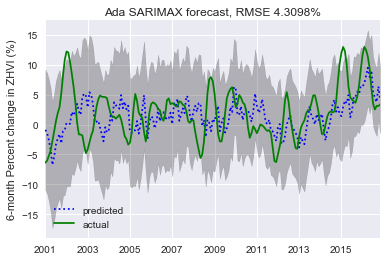

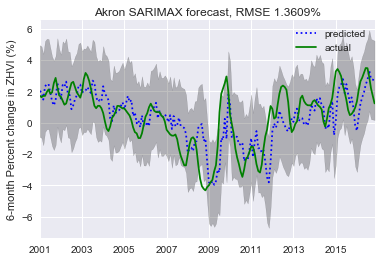

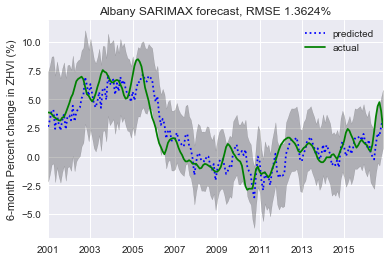

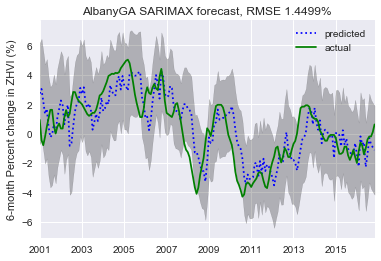

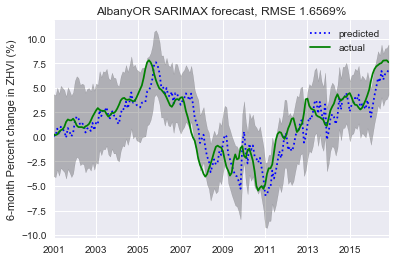

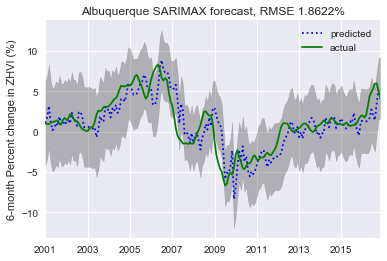

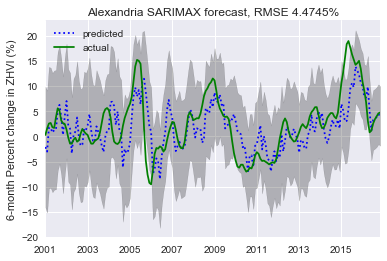

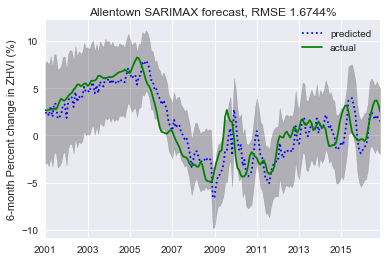

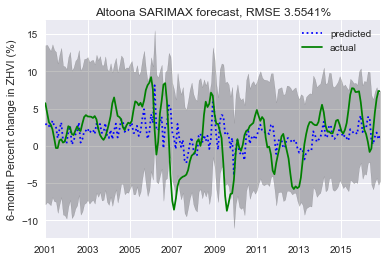

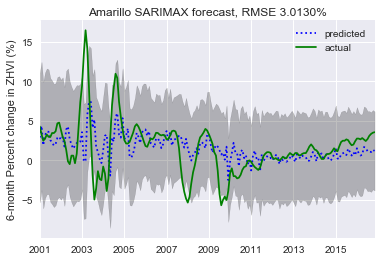

In [4]:
%reset -f 
%matplotlib inline

import sys, os, copy
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt; from matplotlib.pyplot import cm 
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.tsa.stattools as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def getRMSE(x,y):
    # X: Pandas TimeSeries of actual data
    # Y: Either a Pandas TimeSeries of prediction data, OR a Pandas DataFrame with each column as different series 
    diff = x - y
    
    if type(y)== pd.core.series.Series:
        return np.sqrt(diff.pow(2).sum()/diff.count())
    else:
        return np.sqrt(diff.pow(2).sum(axis=0) / diff.count(axis=0))

#Name of Zillow data file

fname = 'Metro_Zhvi_AllHomes_fulldata.csv'

#  Map Zillow RegionID to metro area string

df = pd.read_csv('Data/ZHVI/'+fname,index_col=[1])
df = df.drop(['RegionID','SizeRank'],axis=1)
df.columns = pd.DatetimeIndex(df.columns)

#Create list of cities to run 

%run -i 'Data/ZHVI/metro_dictionaries.py'
reverse_metroString = dict((v, k) for k, v in metroString.items())
fname = 'Metro_Zhvi_AllHomes_fulldata.csv'
df = pd.read_csv('Data/ZHVI/'+fname,index_col=[1])
df = df.drop(['RegionID','SizeRank'],axis=1)
df.columns = pd.DatetimeIndex(df.columns)
cityList = [reverse_metroString[city] for city in df.index]
cityList.sort()

#Comment out this line to run on all cities:
cityList = cityList[0:10]

#Run model

startDate = '1996-04'
endDate = '2017-05'
shiftMonths = 6

for city in cityList:
 
 ts = df.loc[metroString[city],startDate:endDate]
 y = ts
 trainUntil    = '2000-12'
 trainEndIndex = y.index.get_loc(trainUntil).stop
 trainingEnds  = y.index[trainEndIndex]
 testingStarts = y.index[trainEndIndex + shiftMonths - 1]
 trainDateList = y.loc[trainingEnds:,].index
 testDateList  = y.loc[testingStarts:,].index
 results = pd.DataFrame(index=trainDateList, columns=['lower','predicted','upper'])
 model=smt.SARIMAX(y, order=(12, 2, 12), exog=None, enforce_invertibility=False, enforce_stationarity=False)
 res=model.fit()
 
 for i in range(len(testDateList)):
  testDate = testDateList[i]
  myForecast = res.get_prediction(start=trainDateList[i],dynamic=True)  # This will run rolling predictions based on the fitted model
  results.loc[testDate,['lower','upper']] = myForecast.conf_int().loc[testDate,:].values # This is the forecast for the future date
  results.loc[testDate,'predicted'] = myForecast.predicted_mean.loc[testDate]
 
 scaledResults = results.shift(-shiftMonths,axis=0).divide(ts,axis=0) - 1
 scaledResults = scaledResults * 100
 scaledResults.dropna(inplace=True)
 
 # Create the ground-truth against which we're comparing this
 actual = ts.pct_change(periods=shiftMonths).shift(-shiftMonths).dropna() * 100
 actual.name = 'actual'
 scaledResults = scaledResults.join(actual,how='inner').dropna()
 
 ## Plot results 

 ax = scaledResults[['predicted','actual']].plot(style=['b:','g-'])
 ax.set_ylabel('6-month Percent change in ZHVI (%)')
 plt.title('%s SARIMAX forecast, RMSE %.4f%%'%(city,getRMSE(scaledResults['predicted'],scaledResults['actual'])))
 ax.fill_between(scaledResults.index, list(scaledResults['lower'].values), list(scaledResults['upper'].values),color='k',alpha=0.25)
 fn = '/Users/JSCamp/Desktop/pdfs2/' + city + '.pdf'
 plt.savefig(fn,format="pdf")
